# Performance study

We evaluate the performance of the different implementations of the simulator that are proposed in the package.

## Preparation

We load a few packages.

In [1]:
from kleinberg_grid_simulator import parallelize, compute_edt
from collections import defaultdict
from matplotlib import pyplot as plt
from tqdm import tqdm

We make a test function with a dry run to trigger JiT compilation.

In [2]:
def test(**kwargs):
    compute_edt(**{**kwargs, 'n_runs': 1})
    return compute_edt(**kwargs)

Evaluation function:

In [3]:
def performance_study(r=2, min_n=7, max_n=20, with_pure=False, with_para=True):
    numb = [{'n': 2**i, 'r': r, 'julia': False} for i in range(min_n, max_n)]
    juli = [{'n': 2**i, 'r': r} for i in range(min_n, max_n)]

    job_list = numb+juli
    if with_pure:
        pure = [{'n': 2**i, 'r': r, 'julia': False, 'numba': False} for i in range(min_n, max_n)]
        job_list = pure + job_list
    res = parallelize(job_list, function=test, n_jobs=29)
    if with_para:
        para = [{'n': 2**i, 'r': r, 'julia': False, 'parallel': True} for i in range(min_n, max_n)]
        res += [test(**kwargs) for kwargs in tqdm(para)]
    return res

Display function:

In [4]:
def performance_display(res, vf=None, ylabel='Time per step', f=None, flabel="fit"):
    values = defaultdict(dict)
    if vf is None:
        vf = lambda x: x.process_time/x.edt/x.n_runs
    for re in res:
        values[(f'r={re.r}, {"Julia" if re.julia else "Python"}'
               f'{" Numba" if (not re.julia) and re.numba else ""}'
               f'{" //" if re.parallel else ""}')][re.n] = vf(re)

    for r, v in values.items():
        n_s = sorted([n for n in v])
        t_s = [v[n] for n in n_s]
        plt.loglog(n_s, t_s, label=r)
        plt.xlabel('$n$')
        plt.ylabel(ylabel)
    if f is not None:
        plt.loglog(n_s, [f(x) for x in n_s], label=flabel)
    plt.legend()
    plt.show()


## Case $r=2$

### Pure Python performance

In [5]:
res = performance_study(max_n=25, with_pure=True)

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:40<00:00,  2.25s/it]


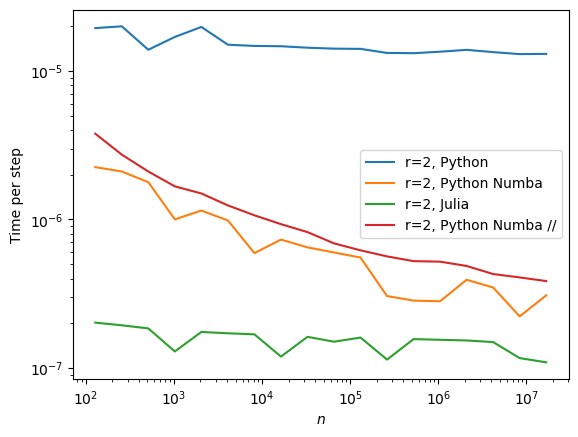

In [6]:
performance_display(res)

We see that the pure Python implemantation is much slower than the other options, so we will discard it from now on.

Note that all implementations yield the same results:

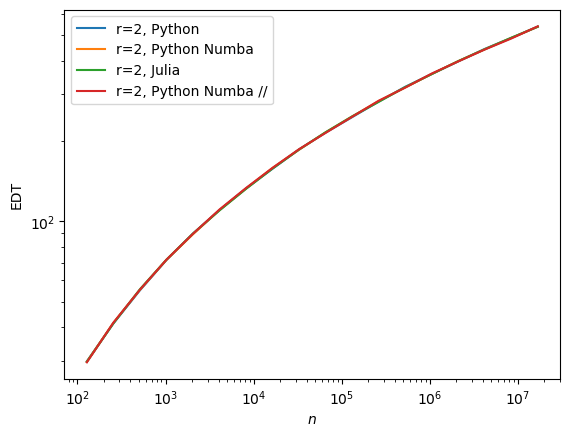

In [7]:
performance_display(res, vf=lambda x: x.edt, ylabel='EDT')

### Numba vs Julia

If we focus on fast implementations we can increase the scope a bit.

100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [02:03<00:00,  2.29s/it]


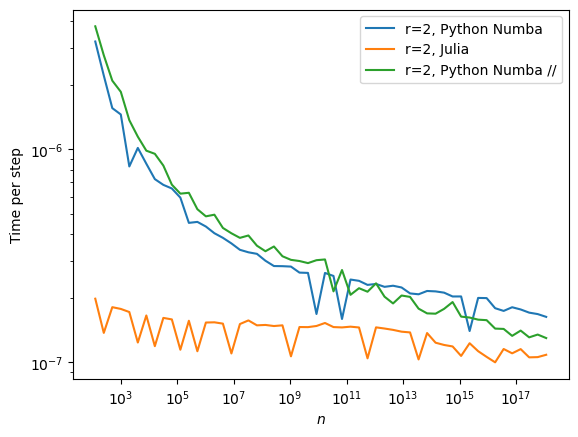

In [8]:
res = performance_study(max_n=61)
performance_display(res)

As always, we can check the consistency of the results.

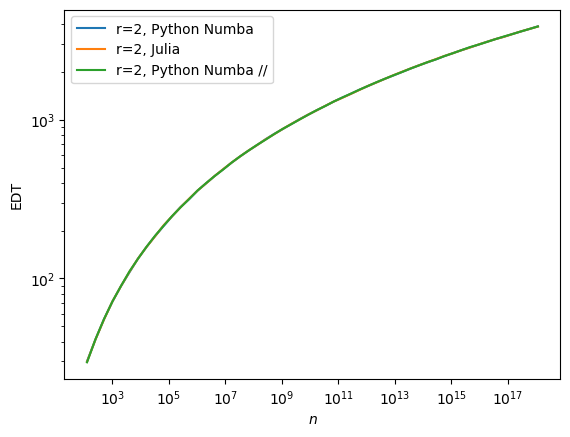

In [9]:
performance_display(res, vf=lambda x: x.edt, ylabel='EDT')

### Julia vs the Universe

The first version of the simulator, from [Kleinberg's Grid Reloaded](https://inria.hal.science/hal-01417096/file/OPODIS2016-camera-ready-paper90.pdf), could go up to $n=10^{20}$.

The second version of the simulator, from [Kleinberg's Grid Unchained](https://inria.hal.science/hal-02052607/document), could go up to $n=10^{41}$.

The current version uses new fixed-length integers up to 1024 bits. What does that mean about performance?

In [10]:
res = parallelize(function=test, values=[{'n': 2**(4*i)} for i in range(2, 75)])

100%|██████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 523.63it/s]


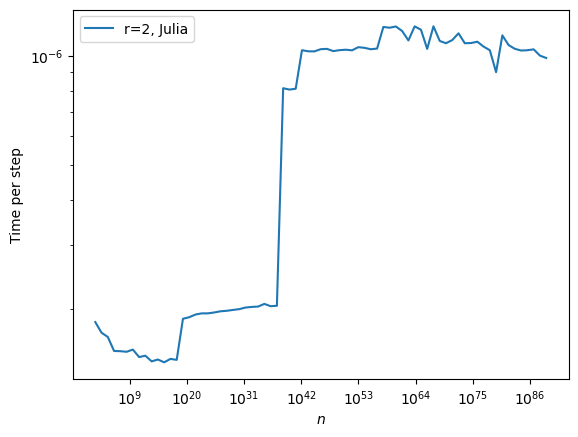

In [11]:
performance_display(res)

In other words: it's much faster!

There is however one issue that needs to be mentionned:

In [12]:
from juliacall import Main as jl
f=lambda e: int(2*jl.log(e)**2-20)

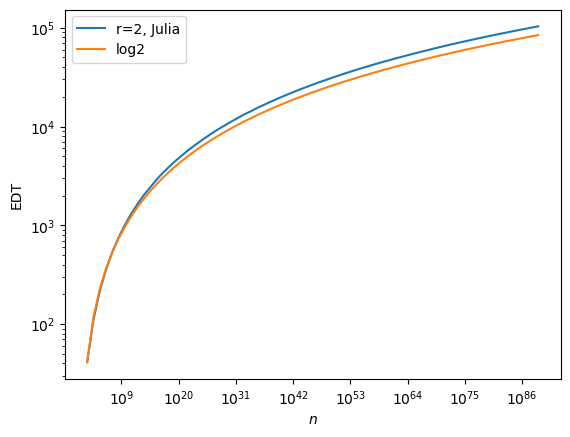

In [13]:
performance_display(res, vf=lambda x: x.edt, ylabel='EDT', f=f, flabel='log2')

The curve above means that the EDT predicted by the simulator does not exactly behave in $\log^2(n)$ as it should.

We believe precision of the random generator is to blame here: it can only give $2^{64}$ distinct values, which is too low with respect to size involved above. In particular, a lot of ranges that are needed for greedy routing, e.g. during the final approach, are never drawed.

To yield better precision, the random generators should be reworked altogether with bigger float precision. This is not in the current roadmap.

## Case $n=1000000$

A transverse study that plays with $r$.

In [14]:
n=1000000
rr = [r/10 for r in range(0, 31)]
numb = [{'n': n, 'r': r, 'julia': False} for r in rr]
juli = [{'n': n, 'r': r} for r in rr]
res = parallelize(numb+juli, function=test, n_jobs=29)

100%|███████████████████████████████████████████████████████████████████████████████████| 62/62 [00:09<00:00,  6.63it/s]


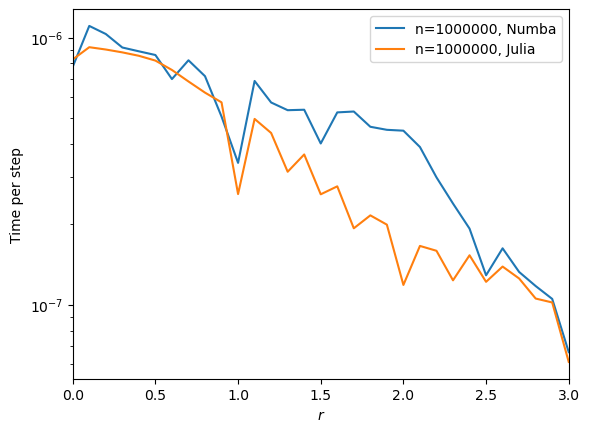

In [15]:
times = defaultdict(list)
for re in res:
    label = f'n={n}, '
    label += "Julia" if re.julia else "Numba"
    times[label].append(re.process_time/re.edt/re.n_runs)
    
for r, v in times.items():
    plt.semilogy(rr, v, label=r)
    plt.xlabel('$r$')
    plt.ylabel('Time per step')
plt.xlim([0, 3])
plt.legend()
plt.show()